In [2]:
import torch
import torch.nn.functional as F
import triton
import triton.language as tl
from triton.runtime import driver
from pprint import pprint

In [3]:
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [4]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
pprint(f"{properties=}", underscore_numbers=True)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

("properties={'max_shared_mem': 101376, 'max_num_regs': 65536, "
 "'multiprocessor_count': 64, 'warpSize': 32, 'sm_clock_rate': 1695000, "
 "'mem_clock_rate': 8001000, 'mem_bus_width': 384}")


In [5]:
@triton.jit
def _silu_forward_kernel(input_ptr: torch.Tensor, output_ptr: torch.Tensor, 
         batch_stride: int, seq_stride: int, 
         L: int, H: int, BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr):
    '''
    Triton kernel for silu.
    silu(x) = x * sigmoid(x)
    x \in R^{B x L x H}
    Args:
        input_ptr: Pointer to the input, shape: (B, L, H)
        output_ptr: Pointer to output, shape: (B, L, H)
        batch_stride: number of elements we move to reach next batch
        seq_stride: number of elements we move to reach next sequence
        L: Sequence Length
        H: Embedding Dimension
    '''
    idx = tl.program_id(0)
    batch_idx = idx // L
    seq_idx = idx % L
    base_idx = batch_idx * batch_stride + seq_idx * seq_stride 
    input_start_ptr = input_ptr + base_idx
    output_start_ptr = output_ptr + base_idx
    col_offsets = tl.arange(0, BLOCK_SIZE)
    
    for k in tl.range(0, tl.cdiv(H, BLOCK_SIZE), num_stages=num_stages):
        offs_col = col_offsets + k * BLOCK_SIZE
        input_ptrs = input_start_ptr + offs_col
        mask = offs_col < H
        x = tl.load(input_ptrs, mask=mask, other=0.0)
        out = x * 1/(1 + tl.exp(-x))
        tl.store(output_start_ptr + offs_col, out, mask=mask)

In [6]:
def silu(x: torch.Tensor) -> torch.Tensor:
    B, L, H = x.shape
    num_stages = 8
    BLOCK_SIZE = 1024
    grid= (B*L,)
    output = torch.empty((B, L, H), dtype=torch.float32, device=x.device)
    _silu_forward_kernel[grid](x, output, x.stride(0), x.stride(1), L, H, BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages)
    return output

In [13]:
@triton.jit
def _silu_backward_kernel(input_ptr: torch.Tensor, dinput_ptr: torch.Tensor, 
                          batch_stride: torch.Tensor, seq_stride: torch.Tensor,
                          L: int, H: int, BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr):
    idx = tl.program_id(0)
    batch_idx = idx // L
    seq_idx = idx % L
    base_idx = batch_idx * batch_stride + seq_idx * seq_stride
    input_start_ptr = input_ptr + base_idx
    
    dinput_start_ptr = dinput_ptr + base_idx
    cols = tl.arange(0, BLOCK_SIZE)
    for k in tl.range(0, tl.cdiv(H, BLOCK_SIZE)):
        col_offsets = cols + k * BLOCK_SIZE
        mask = col_offsets < H
        input_ptrs = input_start_ptr + col_offsets
        x = tl.load(input_ptrs, mask=mask, other=0.0)
        sig = tl.sigmoid(x) 
        dinput = sig + x * sig * (1 - sig)
        tl.store(dinput_start_ptr + col_offsets, dinput, mask=mask)

In [14]:
def silu_backward(x: torch.Tensor):
    B, L, H = x.shape
    num_stages = 8
    BLOCK_SIZE = 1024
    grid= (B*L,)
    output = torch.empty((B, L, H), dtype=torch.float32, device=x.device)
    _silu_backward_kernel[grid](x, output, x.stride(0), x.stride(1), L, H, BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages)
    return output

In [15]:
class SiLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input: torch.Tensor):
        output = silu(input)
        ctx.save_for_backward(input)
        return output
    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        (input, ) = ctx.saved_tensors
        grad_input = silu_backward(input)
        return grad_output * grad_input
        

In [21]:
torch.manual_seed(0)
x_custom = torch.randn((16, 64, 2048), device='cuda', dtype=torch.float32, requires_grad=True)
x_ref = x_custom.clone().detach().requires_grad_(True)


# Use your custom autograd function
y = SiLU.apply(x_custom)

# Define a simple loss; here we just sum all elements.
loss = y.sum()

# Perform backward
loss.backward()


In [22]:
grad_custom = x_custom.grad
# Compute output using the reference implementation.
y_ref = F.silu(x_ref)
loss_ref = y_ref.sum()
loss_ref.backward()
grad_ref = x_ref.grad

if torch.allclose(grad_custom, grad_ref, atol=1e-5, rtol=1e-4):
    print("✅ Gradients match!")
else:
    print("❌ Gradients differ!")

✅ Gradients match!


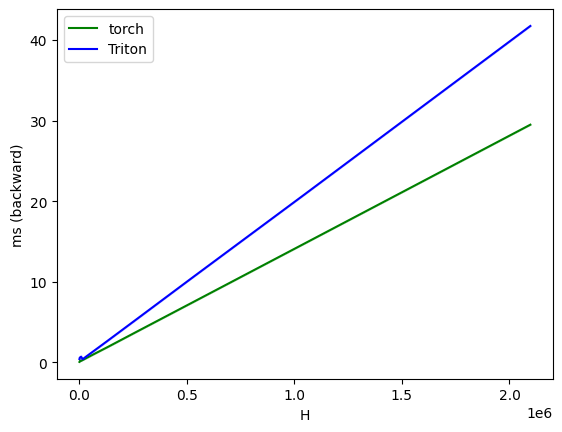

silu-backward-performance-fp32:
            H      torch     Triton
0      1024.0   0.050176   0.405504
1      2048.0   0.114688   0.549888
2      4096.0   0.196608   0.614400
3      8192.0   0.173056   0.689152
4     16384.0   0.287744   0.394240
5     32768.0   0.522240   0.724992
6     65536.0   0.982016   1.366016
7    131072.0   1.882112   2.655232
8    262144.0   3.728384   5.259264
9    524288.0   7.404032  10.482688
10  1048576.0  14.765568  20.865025
11  2097152.0  29.499392  41.755646
None


In [ ]:
import triton.testing

def benchmark_backward(H, provider, L):
    B = 16
    a = torch.randn((B, L, H), device=DEVICE, dtype=torch.float32, requires_grad=True)
    quantiles = [0.5, 0.2, 0.8]

    if provider == ref_lib.lower():
        def run_backward():
            a.grad = None  
            y = F.silu(a)
            loss = y.sum()
            loss.backward()
            torch.cuda.synchronize()
        ms, min_ms, max_ms = triton.testing.do_bench(run_backward, quantiles=quantiles)
    
    elif provider == 'triton':
        def run_backward():
            a.grad = None  
            y = SiLU.apply(a) 
            loss = y.sum()
            loss.backward()
            torch.cuda.synchronize()
        ms, min_ms, max_ms = triton.testing.do_bench(run_backward, quantiles=quantiles)
    
    return ms, min_ms, max_ms

configs = []
ref_lib = "torch"
seq_lengths = [32]
for l in seq_lengths:
    configs.append(
        triton.testing.Benchmark(
            x_names=["H"],
            x_vals=[2**i for i in range(10, 22)],
            line_arg="provider",
            line_vals=[ref_lib.lower(), "triton"],
            line_names=[ref_lib, "Triton"],
            styles=[("green", "-"), ("blue", "-")],
            ylabel="ms (backward)", 
            plot_name="silu-backward-performance-fp32",
            args={"L": l},
        )
    )

@triton.testing.perf_report(configs)
def benchmark(H, provider, L):
    ms, min_ms, max_ms = benchmark_backward(H, provider, L)
    return ms, min_ms, max_ms

print(benchmark.run(show_plots=True, print_data=True))

In [23]:
torch.manual_seed(0)
x = torch.randn((16, 64, 2048), device=DEVICE, dtype=torch.float32)
B, L, H = x.shape

triton_output = SiLU.apply(x)
torch_output = F.silu(x)
if torch.allclose(triton_output, torch_output):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


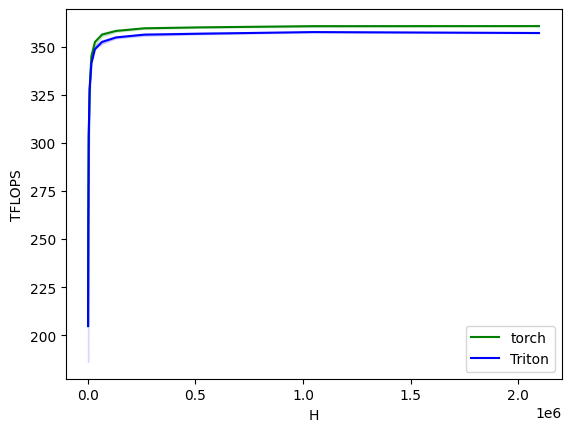

silu-performance-fp32:
            H       torch      Triton
0      1024.0  204.800005  204.800005
1      2048.0  256.000001  256.000001
2      4096.0  303.407407  303.407407
3      8192.0  327.680008  327.680008
4     16384.0  344.926305  341.333321
5     32768.0  352.344077  348.595735
6     65536.0  356.173905  352.344077
7    131072.0  358.120225  354.728020
8    262144.0  359.478367  356.173905
9    524288.0  359.964290  356.658499
10  1048576.0  360.583216  357.509719
11  2097152.0  360.614225  357.022811
None


In [27]:
configs = []
ref_lib = "torch"
seq_lengths = [32]
for l in seq_lengths:
    configs.append(
        triton.testing.Benchmark(
            x_names=["H"],  # Argument names to use as an x-axis for the plot
            x_vals=[2**i for i in range(10, 22)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=[ref_lib.lower(), "triton"] , # Label name for the lines
            line_names=[ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="silu-performance-" +
            ("fp32"),  # Name for the plot, used also as a file name for saving the plot.
            args={"L": l},
        ))
@triton.testing.perf_report(configs)
def benchmark(H, provider, L):
    B = 16
    a = torch.randn((B, L, H), device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: F.silu(a), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: silu(a), quantiles=quantiles)
    # Calculate memory bandwidth: bytes_accessed / runtime_in_seconds
    # Each float32 element is 4 bytes
    bytes_accessed = B * L * H * 4 # Input + Output + gamma
    gb_per_s = lambda ms: bytes_accessed * 1e-9 / (ms * 1e-3)
    
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)


print(benchmark.run(show_plots=True, print_data=True))